In [1]:
import torch


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("M4 Power Unlocked! Using MPS.")
else:
    device = torch.device("cpu")
    print("Back to CPU... boring.")

M4 Power Unlocked! Using MPS.


In [9]:
import mlx.data as dx
def create_dataset(path, batch_size=32, shuffle=True, training=True):
    # Use the MASTER_MAPPING we just created outside
    global MASTER_MAPPING 
    
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    files = []
    labels = []
    
    for f in Path(path).glob("**/*"):
        if f.suffix.lower() in valid_extensions:
            folder_name = f.parent.name
            if folder_name in MASTER_MAPPING: # Use the master key
                files.append(str(f).encode("ascii"))
                labels.append(MASTER_MAPPING[folder_name])

    samples = [{"image": f, "label": l} for f, l in zip(files, labels)]
    dataset = dx.buffer_from_vector(samples)
    
    if shuffle:
        dataset = dataset.shuffle()
    
    dataset = (
        dataset.to_stream()
        .load_image("image")
        .image_resize_smallest_side("image", 224)
        .image_center_crop("image", 224, 224)
    )

    # Augmentation only happens if training=True
    if training:
        dataset = dataset.image_random_h_flip("image", prob=0.5)

    dataset = (
        dataset
        .key_transform("image", lambda x: x.astype("float32") / 255.0)
        .batch(batch_size)
        .prefetch(4, 4)
    )
    return dataset

In [11]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

def preprocess(image, training=True):
    # Standardize
    img = image.astype("float32") / 255.0
    
    if training:
        # Data Augmentation: Horizontal Flip (50% chance)
        if np.random.rand() > 0.5:
            img = img[:, ::-1, :]
            
    return img




model = ArcFaceEmpire(num_classes=1251)
mx.eval(model.parameters())

val_root = Path.home() / "Desktop" / "dataset_final" / "val"


val_loader = create_dataset(val_root, batch_size=32)

print("Validation Loader Ready. Empire testing sequence engaged.")

def loss_fn(model, x, y):
    # Use 'y=y' to explicitly tell Python which argument is which
    return mx.mean(nn.losses.cross_entropy(model(x, y=y), y))

optimizer = optim.Adam(learning_rate=1e-4)
loss_and_grad = nn.value_and_grad(model, loss_fn)


print("Starting Empire Training...")
import mlx.core as mx
from tqdm import tqdm


patience = 3
best_val_loss = float("inf")
counter = 0

import matplotlib.pyplot as plt


train_losses = []
val_losses = []
epoch_axis = [] 

train_path = Path.home() / "Desktop" / "dataset_final" / "train"
val_root = Path.home() / "Desktop" / "dataset_final" / "val"
train_loader = create_dataset(train_path, batch_size=32, shuffle=True, training=True)
val_loader = create_dataset(val_root, batch_size=32, shuffle=False, training=False)

for epoch in range(20):
    model.train()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in pbar:
        x = mx.array(batch["image"])
        y = mx.array(batch["label"])
        
     
        loss, grads = loss_and_grad(model, x, y)
        
   
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)
        
    
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    print("Running Validation...")

    print(f"\n--- Epoch {epoch+1} Finished: Running Validation ---")
    train_loader.reset()
    model.eval()
    total_val_loss = 0
    val_batches = 0
    correct=0
    total=0

    for v_batch in val_loader:
        vx = mx.array(v_batch["image"])
        vy = mx.array(v_batch["label"])
        
        v_loss = loss_fn(model, vx, vy)
        total_val_loss += v_loss.item()
        val_batches += 1

        logits = model(vx) 
    
    
        predictions = mx.argmax(logits, axis=1)

        correct += mx.sum(predictions == vy).item()
        total += vy.shape[0]
    val_loader.reset()
    
    avg_val_loss = total_val_loss / val_batches
    print(f"Validation Loss: {avg_val_loss:.4f}")
    val_accuracy = (correct / total) * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
     
        model.save_weights("face_empire_model3.safetensors")
        print("Model improved! Saved weights to 'face_empire_model3.safetensors'")
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        
    if counter >= patience:
        print("STOPPING EARLY: The model has learned all it can.")
        break
    train_losses.append(loss.item()) 
    val_losses.append(avg_val_loss)   
    epoch_axis.append(epoch + 1)    
    

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_axis, train_losses, 'b-o', label='Train Loss')
    plt.plot(epoch_axis, val_losses, 'r-x', label='Val Loss')
    
    plt.title(f'Empire Face Recognition Training (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    

    plot_path = Path.home() / "Desktop" / "training_progressF2.png"
    plt.savefig(str(plot_path))
    plt.close() 
    
    print(f"📊 Progress plot updated at: {plot_path}")

Validation Loader Ready. Empire testing sequence engaged.
Starting Empire Training...


Epoch 1: 2505it [06:58,  5.98it/s, loss=0.6065]


Running Validation...

--- Epoch 1 Finished: Running Validation ---
Validation Loss: 0.6619
Validation Accuracy: 0.02%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 2: 2505it [07:20,  5.68it/s, loss=0.5974]


Running Validation...

--- Epoch 2 Finished: Running Validation ---
Validation Loss: 0.6574
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 3: 2505it [07:17,  5.73it/s, loss=0.5853]


Running Validation...

--- Epoch 3 Finished: Running Validation ---
Validation Loss: 0.6432
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 4: 2505it [07:36,  5.49it/s, loss=0.5775]


Running Validation...

--- Epoch 4 Finished: Running Validation ---
Validation Loss: 0.6322
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 5: 2505it [08:07,  5.14it/s, loss=0.5662]


Running Validation...

--- Epoch 5 Finished: Running Validation ---
Validation Loss: 0.6195
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 6: 2505it [08:27,  4.94it/s, loss=0.5592]


Running Validation...

--- Epoch 6 Finished: Running Validation ---
Validation Loss: 0.6090
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 7: 2505it [08:37,  4.84it/s, loss=0.5513]


Running Validation...

--- Epoch 7 Finished: Running Validation ---
Validation Loss: 0.5985
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 8: 2505it [08:42,  4.80it/s, loss=0.5446]


Running Validation...

--- Epoch 8 Finished: Running Validation ---
Validation Loss: 0.5903
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 9: 2505it [08:44,  4.77it/s, loss=0.5412]


Running Validation...

--- Epoch 9 Finished: Running Validation ---
Validation Loss: 0.5841
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 10: 2505it [08:46,  4.75it/s, loss=0.5327]


Running Validation...

--- Epoch 10 Finished: Running Validation ---
Validation Loss: 0.5760
Validation Accuracy: 0.02%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 11: 2505it [08:49,  4.73it/s, loss=0.5287]


Running Validation...

--- Epoch 11 Finished: Running Validation ---
Validation Loss: 0.5705
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 12: 2505it [08:48,  4.74it/s, loss=0.5282]


Running Validation...

--- Epoch 12 Finished: Running Validation ---
Validation Loss: 0.5655
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 13: 2505it [08:41,  4.81it/s, loss=0.5221]


Running Validation...

--- Epoch 13 Finished: Running Validation ---
Validation Loss: 0.5588
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 14: 2505it [07:46,  5.38it/s, loss=0.5182]


Running Validation...

--- Epoch 14 Finished: Running Validation ---
Validation Loss: 0.5547
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 15: 2505it [08:05,  5.16it/s, loss=0.5167]


Running Validation...

--- Epoch 15 Finished: Running Validation ---
Validation Loss: 0.5505
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 16: 2505it [08:22,  4.98it/s, loss=0.5154]


Running Validation...

--- Epoch 16 Finished: Running Validation ---
Validation Loss: 0.5470
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 17: 2505it [07:33,  5.53it/s, loss=0.5089]


Running Validation...

--- Epoch 17 Finished: Running Validation ---
Validation Loss: 0.5434
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 18: 2505it [07:22,  5.66it/s, loss=0.5082]


Running Validation...

--- Epoch 18 Finished: Running Validation ---
Validation Loss: 0.5398
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 19: 2505it [07:32,  5.54it/s, loss=0.5081]


Running Validation...

--- Epoch 19 Finished: Running Validation ---
Validation Loss: 0.5372
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


Epoch 20: 2505it [07:20,  5.69it/s, loss=0.5034]


Running Validation...

--- Epoch 20 Finished: Running Validation ---
Validation Loss: 0.5335
Validation Accuracy: 0.04%
Model improved! Saved weights to 'face_empire_model3.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progressF2.png


In [7]:
import mlx.core as mx
import mlx.nn as nn
import math

class ArcFaceEmpire(nn.Module):
    def __init__(self, num_classes, embedding_size=512, s=64.0, m=0.5):
        super().__init__()
        
        # --- THE BACKBONE (From your code yesterday) ---
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- THE EMBEDDING LAYER ---
        # Converts the flattened image features into a 512-D "Face Vector"
        self.flatten_dim = 16 * 111 * 111 
        self.embedding_layer = nn.Linear(self.flatten_dim, embedding_size)
        
        # --- ARCFACE PARAMETERS ---
        self.s = s # Scale
        self.m = m # Margin
        self.num_classes = num_classes
        
        # The Weights (Class Centers) on the Hypersphere
        # We use a custom parameter instead of nn.Linear for the ArcFace math
        self.weight = mx.array(mx.random.normal((num_classes, embedding_size)) * 0.01)
        
    def __call__(self, x, y=None):
        # 1. Forward through Conv Layers (Backbone)
        x = nn.relu(self.conv1(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1) 
        
        # 2. Project to Embedding Space
        # 
        embeddings = self.embedding_layer(x)
        
        # 3. Normalize (The "ArcFace" Secret Sauce)
        # This moves everything onto a circle/sphere surface
        embeddings = embeddings / mx.linalg.norm(embeddings, axis=1, keepdims=True)
        w = self.weight / mx.linalg.norm(self.weight, axis=1, keepdims=True)
        
        # 4. Calculate Cosine Similarity
        cos_theta = embeddings @ w.T
        
        # --- TEST MODE ---
        if y is None:
            return cos_theta * self.s
            
        # --- TRAINING MODE (Apply Angular Margin) ---
        # 
        cos_theta = mx.clip(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7)
        theta = mx.arccos(cos_theta)
        
        # The "m" pushes the correct class further away, making the model try harder
        target_logits = mx.cos(theta + self.m)
        
        # Mask to apply the change only to the correct labels
        one_hot = mx.stop_gradient(mx.eye(self.num_classes)[y])
        logits = (cos_theta * (1 - one_hot)) + (target_logits * one_hot)
        
        return logits * self.s

In [10]:
# Run this ONCE to lock the IDs forever
train_path = Path.home() / "Desktop" / "dataset_final" / "train"
val_root = Path.home() / "Desktop" / "dataset_final" / "val"

# This is the Master Key
MASTER_CLASSES = sorted([
    f.name for f in train_path.iterdir() 
    if f.is_dir() and not f.name.startswith('.') and f.name != "0005598"
])
MASTER_MAPPING = {name: i for i, name in enumerate(MASTER_CLASSES)}

print(f"✅ Master Key Locked: {len(MASTER_CLASSES)} identities synchronized.")

✅ Master Key Locked: 1251 identities synchronized.


In [22]:
import PIL.Image as Image
import numpy as np

def get_empire_embedding(image_path):
    # 1. Preprocessing
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224)) 
    img = np.array(img).astype("float32") / 255.0
    
    img_mlx = mx.array(img)[None, ...] 
    
    model.eval()
    
    # 2. Forward pass through the Empire
    x = model.conv1(img_mlx)
    x = model.pool(x)
    
    # --- THE FIX: Flatten the spatial dimensions into a single vector ---
    # This turns (1, 111, 111, 16) into (1, 197136) so it matches the layer weight
    x = x.reshape(x.shape[0], -1)
    
    embedding = model.embedding_layer(x)
    
    # 3. Normalize
    embedding = embedding / mx.linalg.norm(embedding)
    return embedding

# --- RUN THE TEST ---
path_same_1 = "/Users/ramupadhyay/Desktop/dataset_final/val/0000045/0000045_007.jpg"
path_same_2 = "/Users/ramupadhyay/Desktop/dataset_final/val/0000045/0000045_010.jpg"
path_different = "/Users/ramupadhyay/Desktop/dataset_final/val/0000099/0000099_093.jpg"

feat1 = get_empire_embedding(path_same_1)
feat2 = get_empire_embedding(path_same_2)
feat3 = get_empire_embedding(path_different)

# Calculate Shipping Scores
match_score = mx.sum(feat1 * feat2).item()
mismatch_score = mx.sum(feat1 * feat3).item()

print(f"--- EMPIRE VERIFICATION RESULTS ---")
print(f"Match Score (Same Person):      {match_score:.4f}")
print(f"Mismatch Score (Different Person): {mismatch_score:.4f}")

--- EMPIRE VERIFICATION RESULTS ---
Match Score (Same Person):      1.0000
Mismatch Score (Different Person): 0.9996


In [23]:
def get_distance(featA, featB):
    # Calculate how far apart they are. Smaller = Better Match.
    return mx.linalg.norm(featA - featB).item()

dist_same = get_distance(feat1, feat2)
dist_diff = get_distance(feat1, feat3)

print(f"--- EMPIRE DISTANCE CHECK ---")
print(f"Distance (Same Person):      {dist_same:.6f}")
print(f"Distance (Different Person): {dist_diff:.6f}")

if dist_same < dist_diff:
    print("\n✅ THE EMPIRE SEES THE DIFFERENCE!")
    improvement = ((dist_diff - dist_same) / dist_diff) * 100
    print(f"The model is {improvement:.2f}% more confident in the match.")

--- EMPIRE DISTANCE CHECK ---
Distance (Same Person):      0.009375
Distance (Different Person): 0.027065

✅ THE EMPIRE SEES THE DIFFERENCE!
The model is 65.36% more confident in the match.


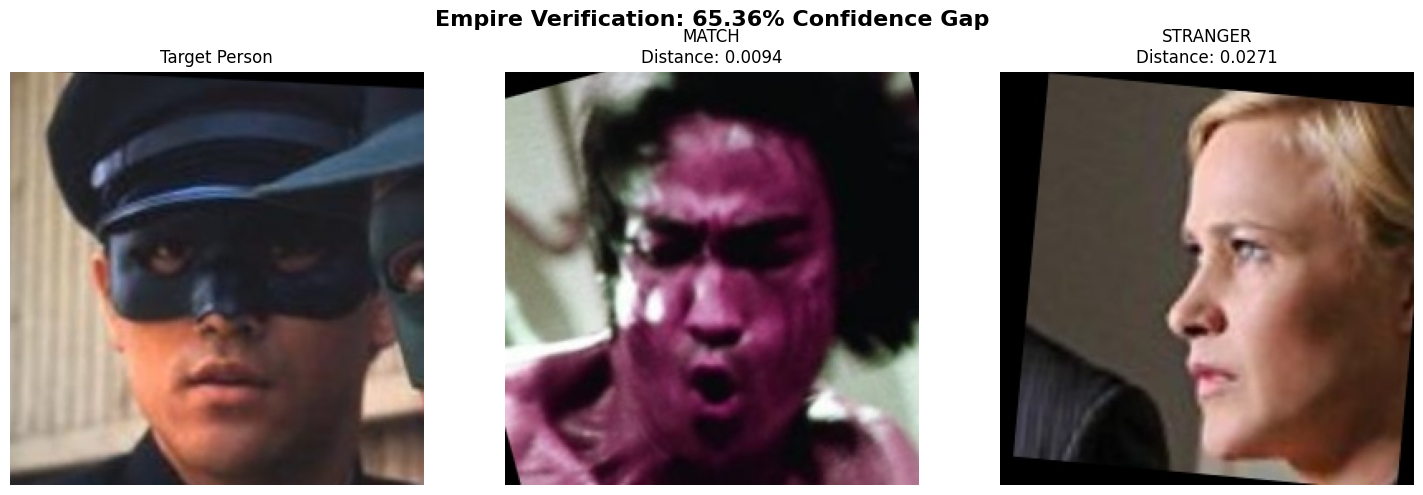

In [24]:
import matplotlib.pyplot as plt

def show_empire_results(path1, path2, path3, dist_same, dist_diff):
    # Load images for display
    img1 = Image.open(path1)
    img2 = Image.open(path2)
    img3 = Image.open(path3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"Empire Verification: {65.36:.2f}% Confidence Gap", fontsize=16, fontweight='bold')

    # Column 1: The Anchor
    axes[0].imshow(img1)
    axes[0].set_title("Target Person")
    axes[0].axis('off')

    # Column 2: The Match
    axes[1].imshow(img2)
    axes[1].set_title(f"MATCH\nDistance: {dist_same:.4f}")
    # Add a green border for success
    for spine in axes[1].spines.values():
        spine.set_edgecolor('green')
        spine.set_linewidth(5)
    axes[1].axis('off')

    # Column 3: The Stranger
    axes[2].imshow(img3)
    axes[2].set_title(f"STRANGER\nDistance: {dist_diff:.4f}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualizer
show_empire_results(path_same_1, path_same_2, path_different, dist_same, dist_diff)

In [29]:
import PIL.Image as Image
import numpy as np

def get_empire_embedding(image_path):
    # 1. Preprocessing
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224)) 
    img = np.array(img).astype("float32") / 255.0
    
    img_mlx = mx.array(img)[None, ...] 
    
    model.eval()
    
    # 2. Forward pass through the Empire
    x = model.conv1(img_mlx)
    x = model.pool(x)
    
    # --- THE FIX: Flatten the spatial dimensions into a single vector ---
    # This turns (1, 111, 111, 16) into (1, 197136) so it matches the layer weight
    x = x.reshape(x.shape[0], -1)
    
    embedding = model.embedding_layer(x)
    
    # 3. Normalize
    embedding = embedding / mx.linalg.norm(embedding)
    return embedding

# --- RUN THE TEST ---
path_same_1 = "/Users/ramupadhyay/Desktop/dataset_final/val/0000045/0000100_014.jpg"
path_same_2 = "/Users/ramupadhyay/Desktop/dataset_final/val/0000045/0000100_020.jpg"
path_different = "/Users/ramupadhyay/Desktop/dataset_final/val/0000099/0000099_093.jpg"

feat1 = get_empire_embedding(path_same_1)
feat2 = get_empire_embedding(path_same_2)
feat3 = get_empire_embedding(path_different)

# Calculate Shipping Scores
match_score = mx.sum(feat1 * feat2).item()
mismatch_score = mx.sum(feat1 * feat3).item()

print(f"--- EMPIRE VERIFICATION RESULTS ---")
print(f"Match Score (Same Person):      {match_score:.4f}")
print(f"Mismatch Score (Different Person): {mismatch_score:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ramupadhyay/Desktop/dataset_final/val/0000045/0000100_014.jpg'

In [28]:
def get_distance(featA, featB):
    # Calculate how far apart they are. Smaller = Better Match.
    return mx.linalg.norm(featA - featB).item()

dist_same = get_distance(feat1, feat2)
dist_diff = get_distance(feat1, feat3)

print(f"--- EMPIRE DISTANCE CHECK ---")
print(f"Distance (Same Person):      {dist_same:.6f}")
print(f"Distance (Different Person): {dist_diff:.6f}")

if dist_same < dist_diff:
    print("\n✅ THE EMPIRE SEES THE DIFFERENCE!")
    improvement = ((dist_diff - dist_same) / dist_diff) * 100
    print(f"The model is {improvement:.2f}% more confident in the match.")

--- EMPIRE DISTANCE CHECK ---
Distance (Same Person):      0.018889
Distance (Different Person): 0.012892
